In [92]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [93]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [95]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (37500, 32, 32, 3)
Train Labels Shape:       (37500, 1)

Validation Images Shape:  (12500, 32, 32, 3)
Validation Labels Shape:  (12500, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


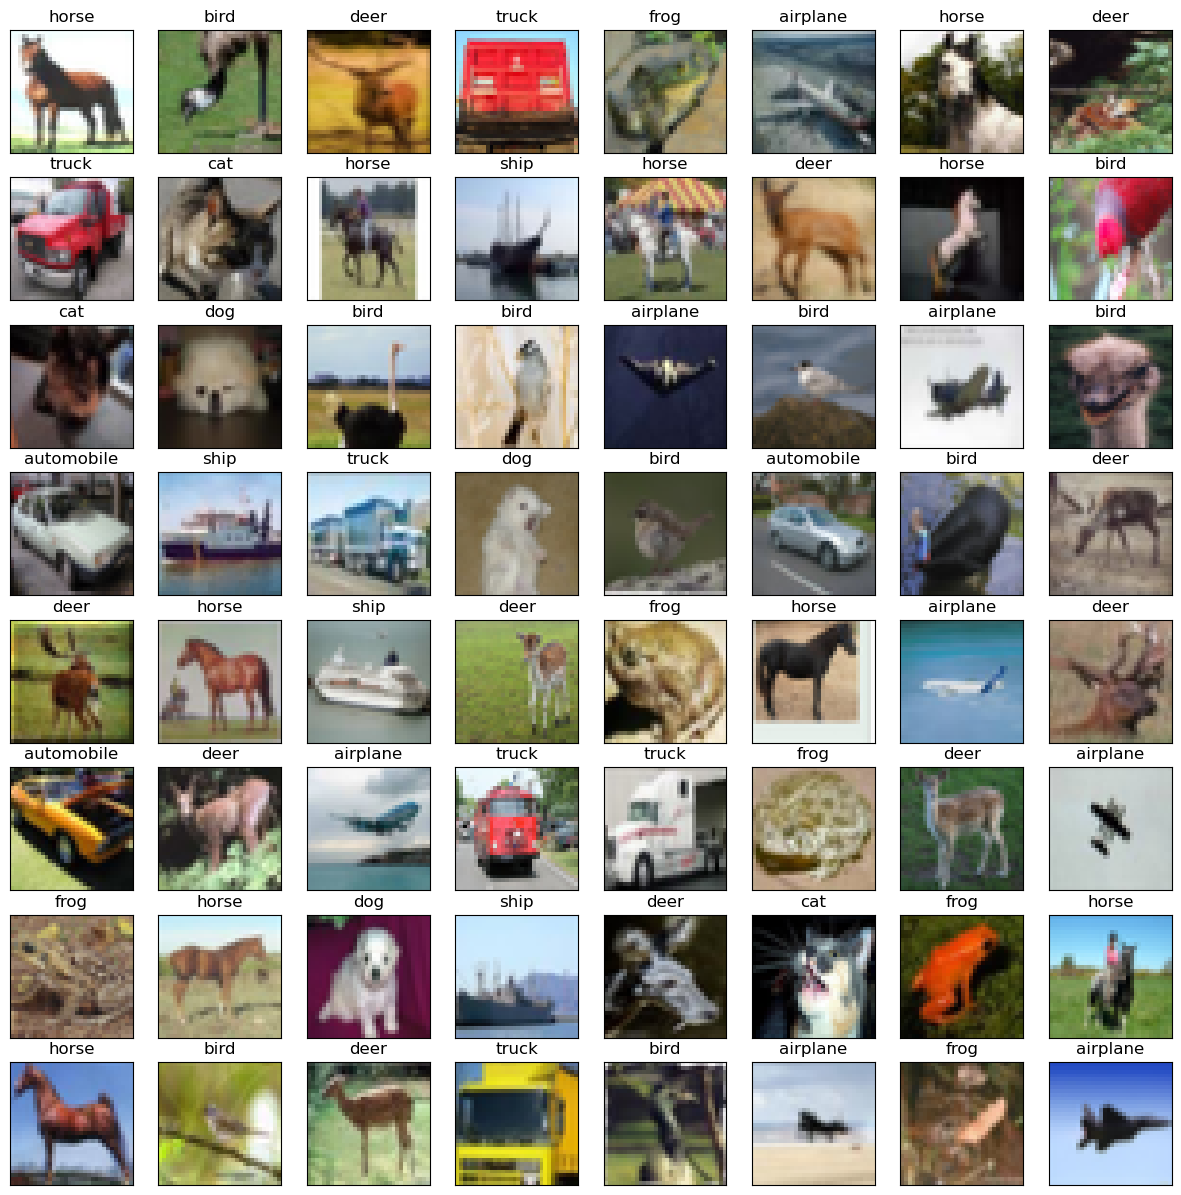

In [96]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [97]:
'''
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)
'''

"\n# Convert pixel values data type to float32\nX_train = X_train.astype('float32')\nX_test  = X_test.astype('float32')\nX_valid = X_valid.astype('float32')\n\n# Calculate the mean and standard deviation of the training images\nmean = np.mean(X_train)\nstd  = np.std(X_train)\n\n# Normalize the data\n# The tiny value 1e-7 is added to prevent division by zero\nX_train = (X_train-mean)/(std+1e-7)\nX_test  = (X_test-mean) /(std+1e-7)\nX_valid = (X_valid-mean)/(std+1e-7)\n"

In [107]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [108]:
IMG_SIZE = 32

# Build model inside strategy scope
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# Resize and preprocess function for ResNet
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# Optional: data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=5000).map(preprocess).map(augment).batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(AUTOTUNE)


In [110]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

In [111]:
epochs = 300

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)

Epoch 1/300
586/586 - 59s - loss: 1.3725 - accuracy: 0.5542 - val_loss: 1.7607 - val_accuracy: 0.4415 - lr: 0.0010 - 59s/epoch - 101ms/step
Epoch 2/300
586/586 - 26s - loss: 1.0083 - accuracy: 0.6651 - val_loss: 2.4491 - val_accuracy: 0.3737 - lr: 0.0010 - 26s/epoch - 44ms/step
Epoch 3/300
586/586 - 26s - loss: 1.2134 - accuracy: 0.5869 - val_loss: 1.8957 - val_accuracy: 0.4139 - lr: 0.0010 - 26s/epoch - 44ms/step
Epoch 4/300
586/586 - 26s - loss: 1.2198 - accuracy: 0.5814 - val_loss: 1.0056 - val_accuracy: 0.6538 - lr: 0.0010 - 26s/epoch - 45ms/step
Epoch 5/300
586/586 - 26s - loss: 1.1147 - accuracy: 0.6250 - val_loss: 1.3972 - val_accuracy: 0.5210 - lr: 0.0010 - 26s/epoch - 45ms/step
Epoch 6/300
586/586 - 26s - loss: 1.0034 - accuracy: 0.6550 - val_loss: 1.2006 - val_accuracy: 0.5912 - lr: 0.0010 - 26s/epoch - 45ms/step
Epoch 7/300
586/586 - 26s - loss: 1.0344 - accuracy: 0.6438 - val_loss: 0.9999 - val_accuracy: 0.6529 - lr: 0.0010 - 26s/epoch - 45ms/step
Epoch 8/300
586/586 - 26s 

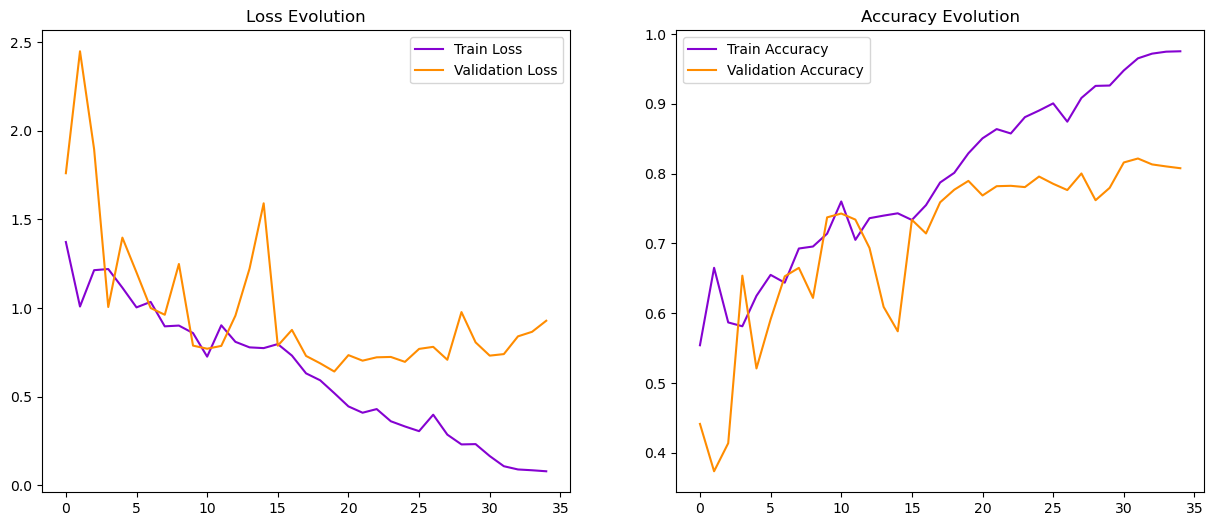

In [112]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [113]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 [==============================] - 4s 11ms/step - loss: 1.7529 - accuracy: 0.4747

Test Accuracy: 0.474700003862381
Test Loss:     1.7529433965682983


In [125]:
# Fetch the raw image from GitHub
url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

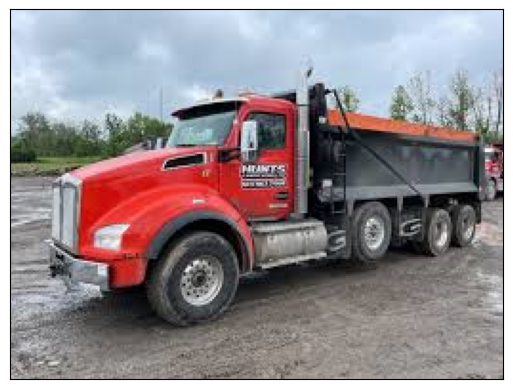

In [126]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [127]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [128]:
prediction = model.predict(image)

1/1 [==============================] - 0s 23ms/step


In [129]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  airplane
